In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import keras
import numpy as np
import os, sys
import pandas as pd
import shap

Using TensorFlow backend.
C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users

In [2]:
data_folder = '../Data/Npy'
fn_prec = '01_prec_training.npy'
fn_temp = '01_temp_training.npy'
fn_mask = '01_mask.npy'
#data_elev = 'Npy/01_dem.npy'
fn_disc = '01_discharge_training.csv'

- import **deephydro module** with networks, losses and metrics

In [3]:
%load_ext autoreload
%autoreload 2
module_folder = os.path.abspath('../src')
#module_folder = 'src/'
if module_folder not in sys.path:
    sys.path.append(module_folder)
import deephydro

from deephydro.utils import limit_gpu_memory
limit_gpu_memory()

W1115 17:01:23.709035  4824 deprecation_wrapper.py:119] From C:\Users\vinograd\Documents\deephydro\DeepHydro\src\deephydro\utils.py:29: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1115 17:01:23.710037  4824 deprecation_wrapper.py:119] From C:\Users\vinograd\Documents\deephydro\DeepHydro\src\deephydro\utils.py:33: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



# Data import

- load output data

In [4]:
import platform
platform.system()

'Windows'

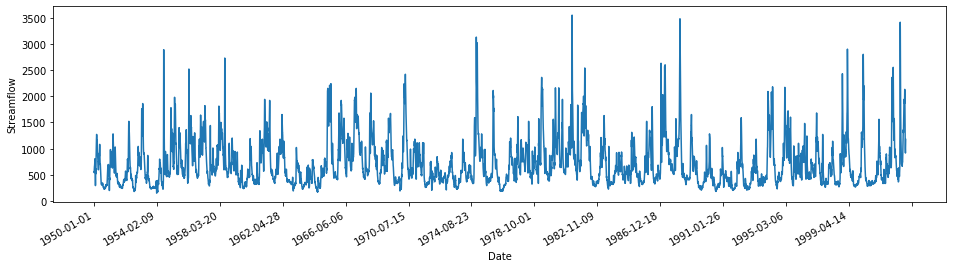

In [5]:
from deephydro import data, visualization
df = data.load_csv_data(data_folder=data_folder, filename=fn_disc)
df.head()
visualization.plot_streamflow(df=df, n_labels=20)

- load input data

In [6]:
x_prec = data.load_from_numpy(data_folder, filename=fn_prec)
x_temp = data.load_from_numpy(data_folder, filename=fn_temp)
x_mask = data.load_from_numpy(data_folder, filename=fn_mask)

In [7]:
print(f'x_prec.shape = {x_prec.shape}')
print(f'x_temp.shape = {x_temp.shape}')
print(f'x_mask.shape = {x_mask.shape}')

x_prec.shape = (19358, 53, 66)
x_temp.shape = (19358, 53, 66)
x_mask.shape = (53, 66)


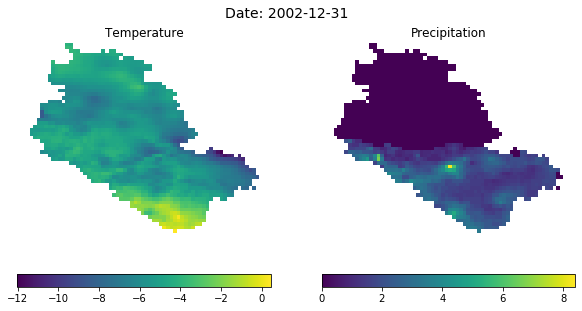

In [8]:
visualization.plot_temp_prec_frame(x_temp, x_prec, x_mask, df, 
                                   frame=-1)


# Data preparation

- define input data `x` and targets `y`

In [9]:
# x: stack temperature and precipitation data
x = np.stack([x_temp, x_prec], axis=-1)

# x: fractional day of year data
x_doy = df['FDOY'].values

# y: streamflow data
y = df['Q'].values

- split train and validation data

In [10]:
# split train and validation data
validation_fraction=0.2
validation_first=False

x_train, x_val, y_train, y_val = \
  data.split_train_validation(x, y, 
                              validation_fraction=validation_fraction,
                              validation_first=validation_first)

x_doy_train, x_doy_val = data.split_DOY_train_validation(x_doy,  
                              validation_fraction=validation_fraction,
                              validation_first=validation_first)

df_train, df_val = data.split_df_train_validation(df, 
                              validation_fraction=validation_fraction,
                              validation_first=validation_first)


In [11]:
print('Shape of x_train = ', x_train.shape)
print('Shape of y_train = ', y_train.shape)
print('Shape of x_val   = ', x_val.shape)
print('Shape of y_val   = ', y_val.shape)

Shape of x_train =  (15487, 53, 66, 2)
Shape of y_train =  (15487,)
Shape of x_val   =  (3871, 53, 66, 2)
Shape of y_val   =  (3871,)


- standardize input (`x_train`) and output data (`y`)

In [12]:
x_train = data.standardize_input_data(x_train)
x_val   = data.standardize_input_data(x_val)

In [13]:
y_train, (Y_MEAN, Y_STD) = data.standardize_targets(y_train)
y_val = (y_val - Y_MEAN) / Y_STD

In [14]:
print(f'Y_MEAN = {Y_MEAN:.3f}')
print(f'Y_STD  = {Y_STD:.3f}')
print('Shape of y_train = ', y_train.shape)

Y_MEAN = 715.437
Y_STD  = 426.762
Shape of y_train =  (15487,)


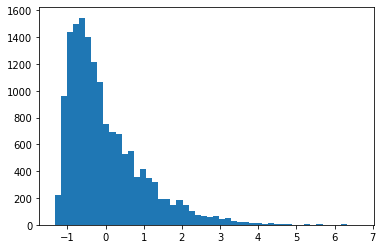

In [15]:
_ = plt.hist(y_train, bins=50)

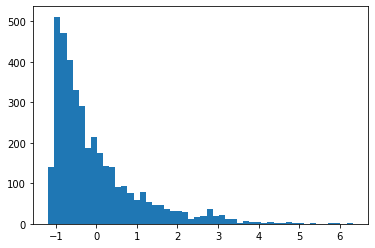

In [16]:
_ = plt.hist(y_val, bins=50)

## Data generator

To sample image sequences, we do not store of all possible image sequences to memory. This would imply storing a lot of overlapping (=redundant) data.

Instead, we use a generator to generate a batch of random sequences. We could build a simple generator function using the `yield` statement, but to exploit parallel processing during batch generation, we will extend the `keras.utils.Sequence` class. 

In [17]:
# length of image sequence
n_frames = 70
# number of GPUs
n_gpus = 1#6

if n_gpus > 1:
    # check if this number of GPUs is available
    import keras.backend as K
    assert n_gpus <= len(K.tensorflow_backend._get_available_gpus())
    
# adjust this to available GPU memory (VRAM)
batch_size = 92*n_gpus

# use day of year ?
day_of_year = True #False
# forecasting ?
forecasting = False
# uncertainty estimation ?
uncertainty = True


In [18]:
import keras.backend as K
K.tensorflow_backend._get_available_gpus()


W1115 17:01:32.383941  4824 deprecation_wrapper.py:119] From C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1115 17:01:32.383941  4824 deprecation_wrapper.py:119] From C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0']

In [19]:
from deephydro.generator import ImageSequenceGenerator
generator_train = ImageSequenceGenerator(data=x_train, labels=y_train,
                                         doy=x_doy_train, 
                                         day_of_year=day_of_year,
                                         batch_size=batch_size, n_frames=n_frames,
                                         stride=1)
generator_val  = ImageSequenceGenerator(data=x_val, labels=y_val,   
                                         doy=x_doy_val, 
                                        day_of_year=day_of_year,
                                         batch_size=batch_size, n_frames=n_frames,
                                         stride=1)

In [20]:
batch = generator_train.__getitem__(0)
if day_of_year:
    print(f'Shape of batch_x im  = {batch[0][0].shape}')
    print(f'Shape of batch_x doy = {batch[0][1].shape}')
    print(f'Shape of batch_y     = {batch[1].shape}')
else:
    print(f'Shape of batch_x = {batch[0].shape}')
    print(f'Shape of batch_y = {batch[1].shape}')


Shape of batch_x im  = (92, 70, 53, 66, 2)
Shape of batch_x doy = (92,)
Shape of batch_y     = (92,)


- the `tensorboard()` callback requires validation_data to be given as fixed data instead of a `generator_val`. Therefore, we create a validation dataset `validation_data` here. Unfortunately, this will involve a lot of redundant/copied data. 

In [21]:
# use 1/3 of validation set for validation
n_validation_data = len(x_val)//3
iterator = range(0, n_validation_data, 1)
validation_data_x = []
validation_data_y = []
for start in iterator:
    end = start+n_frames
    validation_data_x.append(x_val[start:end])
    validation_data_y.append(y_val[end-1])
        
validation_data_x = np.array(validation_data_x)
print(validation_data_x.shape)
validation_data_y = np.array(validation_data_y)
print(validation_data_y.shape)
validation_data = (validation_data_x, validation_data_y)

(1290, 70, 53, 66, 2)
(1290,)


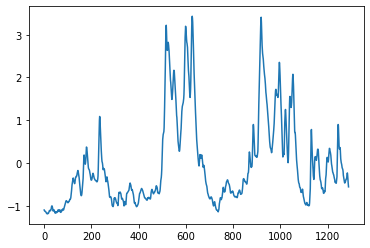

In [22]:
plt.plot(validation_data_y)

# Model

- load model
- predicts the streamflow from a short sequence of temperature and precipitation...

input_shape = (n_frames, *x_train.shape[1:])
from deephydro import networks
# model = networks.nowcasting_model(input_shape, n_filters=16, dayofyear=day_of_year,
#                                   dropout_rate=0.5, 
#                                   batch_norm=True,
#                                   conv2D_preprocessing=True)
model = networks.nowcasting_uncertainty_model(input_shape, n_filters=16, dayofyear=day_of_year,
                                  dropout_rate=0.5, 
                                  batch_norm=True,
                                  conv2D_preprocessing=False)


model.summary(line_length=120)

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

- compile model: loss, optimizer and metrics

In [23]:
from keras import optimizers
from deephydro.losses import mse, logcosh, gauss
from deephydro.metrics import ccc

def build_model(model, 
                loss,
                metrics=ccc,
                optimizer=optimizers.Adam(lr=1e-4), 
                n_gpus:int=1):
    if n_gpus > 1:
        from keras.utils import multi_gpu_model
        parallel_model = multi_gpu_model(model, gpus=n_gpus)
        parallel_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
        return parallel_model
    else:
        model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
        return model


Everything except model plotting works for Kira. 17.10.19

# Saliency map

- using a variant of `DeepLIFT` called `DeepShap` based on Shapley values and implemented in the package [`shap`](https://github.com/slundberg/shap)


```
conda install -c conda-forge shap
pip install tqdm --upgrade # I needed to upgrade tqdm (progress bar)
```

In [24]:
model_name = '../output/model_wdb_doy_nobatchnorm_dropout.h5' #model_wdb_log_dropout_batchnorm.h5'
#model_name = '../output/model_wdb_uncertainty_noDOY.h5'
n_frames = 70
Y_MEAN = 715.437
Y_STD  = 426.762

reload_model = True

if reload_model:
    from keras.models import load_model
    from deephydro.metrics import ccc
    from deephydro.losses import gauss
    model = load_model(model_name, 
               custom_objects={'ccc': ccc, 'gauss': gauss})

W1115 17:01:34.477067  4824 deprecation_wrapper.py:119] From C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1115 17:01:34.682069  4824 deprecation.py:506] From C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1115 17:01:41.150144  4824 deprecation_wrapper.py:119] From C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1115 17:01:41.935169  4824 deprecation.py:323] From C:\Users\vinograd\Anaconda3_12\envs\tf_for_hydro

In [25]:
# get a batch of images
batch = generator_val.__getitem__(0)
# select a single image
im = batch[0][12]

IndexError: list index out of range

In [26]:
type(batch)

tuple

In [ ]:
im.shape

In [33]:
batch[0][0].shape # images

(92, 70, 53, 66, 2)

In [34]:
batch[0][1].shape # doys

(92,)

In [37]:
batch[1].shape # streamflow values (ys)

(92,)

In [ ]:
model.summary()

In [ ]:
im_tuple=tuple(np.array(batch[0][12],batch[1][12]))

In [ ]:
!pip show tensorflow

!pip install shap

In [ ]:
model.layers[0].input.shape

In [ ]:
batch.shape

In [ ]:
import shap
import numpy as np
def shap_values_nodoy(model, generator, image, background_batches=-1):
    # background_batches=-1 stands for averaging across all batches in the generator
    if background_batches==-1:
        background_batches=generator.__len__()

    # select a set of background examples to take an expectation over
    # this takes the mean over a number of batches of inputs images
    background = np.mean(np.array([np.mean(generator.__getitem__(i)[0], axis=0) for i in range(background_batches)])
                         , axis=0) # add "i" so we get Different items from the generator
    #generator.__getitem__(i) returns batch_xs, batch_ys
    
    print(background.shape,background[np.newaxis, ...].shape,np.array([background[np.newaxis, ...],0.5]).shape)
    
    # explain predictions
    e = shap.DeepExplainer(model, 
                           #np.array([
                               background[np.newaxis, ...])
                           #]))#,[0.5]]))
    # ...or pass tensors directly
    #e = shap.DeepExplainer((model.layers[0].input[0], model.layers[-1].output), background)#[np.newaxis, ...])
    """
    classshap.DeepExplainer(model, data, session=None, learning_phase_flags=None)
Meant to approximate SHAP values for deep learning models.

    shap_values(X, ranked_outputs=None, output_rank_order='max')
Return approximate SHAP values for the model applied to the data given by X.

X :list,
if framework == ‘tensorflow’: numpy.array.
"""
    shap_values = e.shap_values(image[np.newaxis, ...])[0][0]

    return shap_values

im= generator_val.__getitem__(0)[0][0]
shap0 = shap_values_nodoy(model, generator=generator_train, image=im)#_tuple)
print(shap0.shape)

In [ ]:
try_doy = np.ones((1,1))
print(try_doy.shape)
try_doy[0,0]=batch[0][1][0]
print(try_doy.shape)
print(try_doy)
#print(batch[0][0][0][np.newaxis, ...].shape,np.expand_dims(batch[0][1][0], axis=1).shape)
e = shap.DeepExplainer(model, [batch[0][0][0][np.newaxis, ...],try_doy])
shap_values = e.shap_values([batch[0][0][0][np.newaxis, ...],try_doy])[0][0]
#shap0 = shap_values_nodoy(model, generator=generator_train, image=im)#_tuple)
print(shap_values.shape)

In [61]:
def shap_values_doy(model, generator, image, background_batches=-1):
    # background_batches=-1 stands for averaging across all batches in the generator
    if background_batches==-1:
        background_batches=generator.__len__()

    # select a set of background examples to take an expectation over
    # this takes the mean over a number of batches of inputs images
    background0 = np.mean(np.array([np.mean(generator.__getitem__(i)[0][0], axis=0) for i in range(background_batches)])
                         , axis=0) # add "i" so we get Different items from the generator
    background1 = np.mean(np.array([np.mean(generator.__getitem__(i)[0][1], axis=0) for i in range(background_batches)])
                         , axis=0)
    try_doy1 = np.ones((1,1))
    print(try_doy1.shape)
    try_doy1[0,0]=background1
    print(try_doy1)
    #generator.__getitem__(i) returns batch_xs, batch_ys
    
    print(background0.shape,background0[np.newaxis, ...].shape,
          background1.shape,background1[np.newaxis, ...].shape)#np.array([background[np.newaxis, ...],0.5]).shape)
    
    # explain predictions
    e = shap.DeepExplainer(model, 
                           #np.array([
                               [background0[np.newaxis, ...],try_doy1])
                           #]))#,[0.5]]))
    # ...or pass tensors directly
    #e = shap.DeepExplainer((model.layers[0].input[0], model.layers[-1].output), background)#[np.newaxis, ...])
    """
    classshap.DeepExplainer(model, data, session=None, learning_phase_flags=None)
Meant to approximate SHAP values for deep learning models.

    shap_values(X, ranked_outputs=None, output_rank_order='max')
Return approximate SHAP values for the model applied to the data given by X.

X :list,
if framework == ‘tensorflow’: numpy.array.
"""
    shap_values = e.shap_values(image#[np.newaxis, ...]
                               )
    print(len(shap_values),len(shap_values[0]))#,shap_values[0].shape)
    shap_values =shap_values[0]#[0]

    return shap_values

im=[batch[0][0][0][np.newaxis, ...],try_doy]
shap0 = shap_values_doy(model, generator=generator_train, image=im)#_tuple)
print(shap0[1].shape)

(1, 1)
[[0.49945995]]
(70, 53, 66, 2) (1, 70, 53, 66, 2) () (1,)
1 2
(1, 1)


In [63]:
shap0[1] # importance of doy

array([[0.02428194]])

In [65]:
shap0[0].shape # saliency maps for temp and precip

(1, 70, 53, 66, 2)

!pip uninstall numpy

from deephydro.visualization import plot_saliency_map
plot_saliency_map(image=im, shap_values=shap0, mask=x_mask)

In [ ]:
from saliency_scr import *
stats= plot_saliency_return_stats(im, shap0, x_mask,"../Plots/saliency_figs/shap_nodoy_bars_val000.png")

In [ ]:
stats.to_excel("../Plots/saliency_stats/shap_nodoy_min_mean_max_sum_val000.xls")


!pip install xlwt

In [ ]:
len(generator_train[0])

In [ ]:
import shap
shap_trainset = saliency_map(model, generator=generator_train, image=im,background_batches=len(generator_train))#_tuple)

In [ ]:
len([np.mean(generator_train.__getitem__(0)[0], axis=0) for _ in range(6)])

In [ ]:
np.array([np.mean(generator_train.__getitem__(i)[0], axis=0) for i in range(6)]).shape

In [ ]:
generator_train.data.shape

In [ ]:
generator_train.__len__()


In [ ]:
len(generator_train.__getitem__(0)[0])

In [ ]:
generator_train.__getitem__(0)[1].shape

In [ ]:
model.input

In [ ]:
model.get_layer('model_1').get_input_at(-1)

In [ ]:
model.layers[1].output


In [ ]:
model.get_input_at(0)

In [ ]:
def grad_convlstm(input_model, image,#predictions, 
                         #prop_from_layer,
                         #prop_to_layer='conv_lst_m2d_2', 
                         normalize=True,abs_w=False,posit_w=False):
    """GradCAM that works for regression output & multidim input for lstm model """
    print(image.shape)
    preprocessed_input = np.expand_dims(image, 0)#load_image(img_path)
    print("preprocessed_input.shape ",preprocessed_input.shape)
    #img = np.expand_dims(img, 0)
    predictions = input_model.predict(preprocessed_input)[0][0]
    print(predictions)
    #predicted_class = predictions    
    prop_from_layer = input_model.layers[-1].name #last dense
    prop_to_layer = input_model.layers[1].name #first lambda # convlstm | last = -4
    print("prop_to_layer ",prop_to_layer)
    y_c = input_model.get_layer(prop_from_layer).output#[...,i,j,cls]
    conv_output = input_model.get_layer(prop_to_layer).output#get_output_at(1)#output
    grads = K.gradients(y_c, conv_output)[0]
    print("output, grads_val shapes: ",conv_output.shape, grads.shape)
    """
    Arguments:
    loss: Scalar tensor to minimize.
    variables: List of variables.
    Returns: A gradients tensor."""
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.get_input_at(0)#[0]#input#get_input_at(0) for models with more inputs than just an image
                                   #layers[0].input#
                                   ], [conv_output, grads])
    """The part of code snippet is as follows -

    final_conv_layer = get_output_layer(model, "conv5_3")
    get_output = K.function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img])
In this code, there is a model from which "conv5_3" layer is extracted (line 1). 
iN the function K.function(), first argument is input to this model and second is set of 2 
outputs - one for convolution and second for softmax output at the last layer.

As per the Keras/Tensorflow manual, this function runs the computation graph that we have created 
in the code, taking input from the first parameter and extracting the number of outputs as per the
 layers mentioned in the second parameter. Thus, conv_outputs are output of final_conv_layer and 
 predictions are output of model.layers[-1] i.e. last layer of the model.
    """
    output, grads_val = gradient_function([preprocessed_input])
    print("output, grads_val shapes: ",output.shape, grads_val.shape)
    print("output, grads_val: ",output, grads_val)
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    print("output, grads_val shapes: ",output.shape, grads_val.shape)
    #print("output[0, :], grads_val[0, :, :, :] ; ",output, grads_val)
    weights = np.mean(grads_val, axis=(0, 1,2))#,3)) # here's the change for our multidim images
    
    if abs_w:
        weights = abs(weights)
    if posit_w:
        weights=np.maximum(weights,0)
        
    cam = np.dot(output, weights) #*abs(grads_val) or max(grads_val,0)
    img_dim = image.shape[1:3] #works for all convlstm layers except the last since it has no temporal dim
    if Debug:
        print("image shape: ", image.shape)
        print("cam shape: ", cam.shape)
        print("img_dim: ",img_dim)
        #print("input_model.output ",input_model.output)#str(K.eval(input_model.output))) #str(y_true.eval())
        #print("y_c: ", y_c)
        #print("conv_output: ",conv_output)
        #print("K.gradients(y_c, conv_output) ", K.gradients(y_c, conv_output))
        #print("K.gradients(y_c, conv_output)[0] aka grads: ", grads)
        #print("gradient_function: ",gradient_function)
        print("output.shape, grads_val.shape: ",output.shape, grads_val.shape)
        #print("output, grads_val: ",output, grads_val)
        print("weights.shape : ",weights.shape)
    # Process CAM
    print("cam T shape: ", cam.T.shape)
    unresizedcam=cam
    cam = cv2.resize(cam.T, img_dim)#[::-1])#, cv2.INTER_LINEAR) #cv2.resize(image,(width,height))
    print("resized cam shape: ", cam.shape)
    cam = np.maximum(cam, 0)
    cam_max = cam.max() 
    if cam_max != 0 and normalize: 
        cam = cam / cam_max
    return cam,predicted_class, unresizedcam
grad_convlstm(model, im)

In [ ]:
batch[1]

In [ ]:
batch[0].shape

In [ ]:
len(batch)

In [ ]:
shap.DeepExplainer.shap_values